In [4]:
import numpy as np
import math
import pandas as pd
import cv2
import os
#import tqdm
#from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
# import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

# from utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers import *

# from keras.applications import MobileNetV2
# from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json
from keras import regularizers

#from keras.initializers import he_normal

from keras.models import load_model
from math import sqrt



In [5]:
target_size = [608, 608]

target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

class_num = 1     ## item

categories = ['bom'] # details of classes

In [3]:
# Loading output of VGG Image Annotation tool and create a dataframe

region_data = []
r_data = pd.DataFrame()

for i in range(1, 28):
    via_folder = '/Users/subrata/workstation/jupyterFiles/yolo_data_file/via_region_data_drg_test_' + str(i) + '.csv'
    region = pd.read_csv(via_folder)
    region_data.append(region)
    
r_data = pd.concat(region_data).reset_index()

r_data_master = r_data[~r_data['region_shape_attributes'].str.contains('{}')].reset_index(drop=True) # remove drgs having no bbox info
r_data_master_unique = r_data_master.drop_duplicates('#filename', keep=False).reset_index(drop=True) # remove duplicate rows
r_data_master_unique.drop(r_data_master_unique.columns[[0, 2, 3, 4, 5]], axis=1, inplace=True) # reduce unnecessary columns

num_images_in_data_master = r_data_master_unique["#filename"].nunique()
r_data_master_image_list = r_data_master_unique["#filename"].tolist()


In [4]:
print(r_data_master_unique.isnull().any())   ## check whether any Nan value in any cell
print('==============')
print(r_data_master_unique.eq(0).any())  ## check whether any '0' value in any cell


#filename                  False
region_shape_attributes    False
region_attributes          False
dtype: bool
#filename                  False
region_shape_attributes    False
region_attributes          False
dtype: bool


In [5]:
## make an image list

num_image_folder = []
drg_image = []

for i in range(1, 28):
    drg_folder = 'drg_test_' + str(i)
    drg_directory = '/Users/subrata/workstation/jupyterFiles/yolo_data_file/' + drg_folder
    inter_var_1 = drg_directory + '/{}'
    drg_folder = [inter_var_1.format(i) for i in os.listdir(drg_directory)]
    num_image_folder.append(len(drg_folder))
    drg_image.append(drg_folder)

print('Number of images in folders = ', num_image_folder)
num_images = len(drg_image)
print('Number of image folders = ', num_images)


Number of images in folders =  [36, 36, 36, 42, 36, 41, 35, 54, 54, 40, 106, 54, 61, 53, 98, 97, 95, 99, 12, 32, 45, 45, 45, 47, 46, 66, 58]
Number of image folders =  27


In [6]:
## drg_image above is a list of lists. We need to flatten this and create a dataframe: 

from itertools import chain

drg_image_path_df = pd.DataFrame()

k = list(chain.from_iterable(map(list, drg_image)))
drg_image = k
drg_image.sort() # Sorting the list

drg_image_path_values = pd.Series(drg_image)
drg_image_path_df.insert(loc=0, column='i_path', value = drg_image_path_values)

drg_image_path_df.tail(3)


,i_path
1466,/Users/subrata/workstation/jupyterFiles/yolo_d...
1467,/Users/subrata/workstation/jupyterFiles/yolo_d...
1468,/Users/subrata/workstation/jupyterFiles/yolo_d...


In [7]:
# remove duplicate drawings across folders and create a column for only drg. no.

drg_image_path_df['drg_no'] = drg_image_path_df['i_path'].apply(lambda x: x.split('/')[-1])
drg_image_path_df = drg_image_path_df.drop_duplicates(subset='drg_no').reset_index(drop=True)
# drg_image_path_df = drg_image_path_df.drop('drg_no', axis=1)
drg_image_path_df.tail(3)

,i_path,drg_no
1453,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-01-11-Model-page-001.jpg
1454,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-00-Model-page-001.jpg
1455,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-02-Model-page-001.jpg


In [8]:
# merge two data frames on drg.no. or file name and create a combined dataframe with required columns :

merged_drg_data = pd.merge(drg_image_path_df.rename(columns={'drg_no': '#filename'}), r_data_master_unique, on='#filename')
merged_drg_data.tail(3)

,i_path,#filename,region_shape_attributes,region_attributes
1429,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-01-11-Model-page-001.jpg,"{""name"":""rect"",""x"":1161,""y"":513,""width"":500,""h...","{""text"":""bom""}"
1430,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-00-Model-page-001.jpg,"{""name"":""rect"",""x"":1051,""y"":709,""width"":608,""h...","{""text"":""bom""}"
1431,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-02-Model-page-001.jpg,"{""name"":""rect"",""x"":1138,""y"":874,""width"":517,""h...","{""text"":""bom""}"


In [9]:
# Making a dataframe for Image_id, image path, x, y, width, height, class, image_width, image_height :

x = []  # co-ordinate of bbox left-top corner and NOT center of bbox as given by via
y = []  # co-ordinate of bbox left-top corner and NOT center of bbox as given by via
width = []  # of boundary box
height = []  # of boundary box
obj_class = []
i_width = []
i_height = []
img_path = []

for i in range(len(merged_drg_data)):
    
    # for x, y, width, height :
    r_size = merged_drg_data.values[i, 2][1:(len(merged_drg_data.values[i, 2])-1)]
    r_size_par = r_size.split(",")
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    # for object class :
    r_attribs = merged_drg_data.values[i, 3][1:(len(merged_drg_data.values[i, 3])-1)]
    if r_attribs == '':
        this_class = 0
    else:
        this_class = 1
    obj_class.append(this_class)
    
    # for image width, height :
    foto_path = merged_drg_data.values[i,0]
    bgr_image = cv2.imread(foto_path)
    image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    i_ht, i_wd, _ = image.shape
    i_height.append(i_ht)
    i_width.append(i_wd)

# making the dataframe :    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)

merged_drg_data.insert(loc=2, column='x', value=x_values)
merged_drg_data.insert(loc=3, column='y', value=y_values)
merged_drg_data.insert(loc=4, column='width', value=width_values)
merged_drg_data.insert(loc=5, column='height', value=height_values)
merged_drg_data.insert(loc=6, column='obj_class', value=class_values)
merged_drg_data.insert(loc=7, column='img_wd', value=i_width_values)
merged_drg_data.insert(loc=8, column='img_ht', value=i_height_values)

merged_drg_data.drop(merged_drg_data.columns[[9, 10]], axis=1, inplace=True) # reduce unnecessary columns
merged_drg_data.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

merged_drg_data.tail(3)


,i_path,img_id,x,y,width,height,obj_class,img_wd,img_ht
1429,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-01-11-Model-page-001.jpg,1161,513,500,426,1,1754,1240
1430,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-00-Model-page-001.jpg,1051,709,608,229,1,1754,1240
1431,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-02-Model-page-001.jpg,1138,874,517,71,1,1754,1240


In [10]:
def single_image_info(lines):
    
    ## lines will be a dataframe like, for i in range(num_images), lines = r_new_data[i*5:(i+1)*5]
    
    pic_path = lines.iat[0, 0]
    img_width = lines.iat[0, 7].astype(np.float32)
    img_height = lines.iat[0, 8].astype(np.float32)
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        
        label = lines['obj_class'][i]
        x_min, y_min, x_max, y_max = float(lines.iat[i,2]), float(lines.iat[i,3]), float(lines.iat[i,2]+lines.iat[i,4]), float(lines.iat[i,3]+lines.iat[i,5])
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.float32)
    
    return pic_path, boxes, labels, img_width, img_height  ## boxes are in format xmin, ymin, xmax, ymax


In [11]:
## Creating the complete data set :

all_image_line = []
limit_lower = 0
limit_upper = 0

for i in range(len(merged_drg_data)):

    image_line = []
    
    img = merged_drg_data['img_id'][limit_upper]
    kount = merged_drg_data['img_id'].value_counts()[img]    ## this gives no. of same images with region data of multiple categories
       
    limit_lower = limit_upper
    limit_upper = limit_lower + kount
    
    lines = merged_drg_data[limit_lower:limit_upper].reset_index(drop=True)
    """
    print('===================', i)
    print(img)
    print(limit_lower)
    print(limit_upper)
    """
    
    pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
                                    
    image_line.append(pic_path)                  ## pic_path = path of the image
    image_line.append(boxes)                     ## boxes are in format xmin, ymin, xmax, ymax
    image_line.append(labels)                    ## labels are either 1 or 0
    image_line.append(img_width)
    image_line.append(img_height)
    all_image_line.append(image_line)
    
print(len(all_image_line))
print(all_image_line[1431])   ##  boxes are in format xmin, ymin, xmax, ymax

1432
['/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_9/10834-2-20-SWZ-04-02-Model-page-001.jpg', array([[1138.,  874., 1655.,  945.]], dtype=float32), array([1.], dtype=float32), 1754.0, 1240.0]


In [12]:
# Train and Test split

data_train_val, data_test = train_test_split(all_image_line, train_size = 0.9 , shuffle = True)
data_train, data_val = train_test_split(data_train_val, train_size = 0.80 , shuffle = True)

num_all_bbox = len(all_image_line) * len(all_image_line[0][2])
num_bb_train = len(data_train) * len(data_train[0][2])
num_bb_val = len(data_val) * len(data_val[0][2])
num_bb_test = len(data_test) * len(data_test[0][2])
print(num_all_bbox, num_bb_train, num_bb_val, num_bb_test)

1432 1030 258 144


In [13]:
image_index = []
image_resized = []
image_y_true = []

for i in range(len(data_train)):

    y_true = np.zeros((1,5), np.float32)
    img_resized = np.zeros((target_size[0], target_size[1]), np.float32)

    y_true[0][0] = data_train[i][2][0]
    y_true[0][1] = data_train[i][1][0][0] / data_train[i][3]
    y_true[0][2] = data_train[i][1][0][1] / data_train[i][4]
    y_true[0][3] = data_train[i][1][0][2] / data_train[i][3]
    y_true[0][4] = data_train[i][1][0][3] / data_train[i][4]

    image_y_true.append(y_true)

    bw_img = cv2.imread(data_train[i][0], cv2.IMREAD_GRAYSCALE)
    # img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(bw_img,(target_size[0], target_size[1]), interpolation=cv2.INTER_CUBIC)
    img_resized = img_resized / 255.0
    img_resized = img_resized.reshape((608,608,1))

    image_resized.append(img_resized)

X_train = np.array(image_resized).astype(np.float32)
Y_train = np.array(image_y_true).astype(np.float32)   

In [14]:
image_index = []
image_resized = []
image_y_true = []

for i in range(len(data_val)):

    y_true = np.zeros((1,5), np.float32)
    img_resized = np.zeros((target_size[0], target_size[1]), np.float32)
    
    y_true[0][0] = data_val[i][2][0]
    y_true[0][1] = data_val[i][1][0][0] / data_val[i][3]
    y_true[0][2] = data_val[i][1][0][1] / data_val[i][4]
    y_true[0][3] = data_val[i][1][0][2] / data_val[i][3]
    y_true[0][4] = data_val[i][1][0][3] / data_val[i][4]

    image_y_true.append(y_true)

    bw_img = cv2.imread(data_val[i][0], cv2.IMREAD_GRAYSCALE)
    # img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(bw_img,(target_size[0], target_size[1]), interpolation=cv2.INTER_CUBIC)
    img_resized = img_resized / 255.0
    img_resized = img_resized.reshape((608,608,1))

    image_resized.append(img_resized)

X_val = np.array(image_resized).astype(np.float32)
Y_val = np.array(image_y_true).astype(np.float32)   

In [15]:
image_index = []
image_resized = []
image_y_true = []

for i in range(len(data_test)):

    y_true = np.zeros((1,5), np.float32)
    img_resized = np.zeros((target_size[0], target_size[1]), np.float32)

    y_true[0][0] = data_test[i][2][0]
    y_true[0][1] = data_test[i][1][0][0] / data_test[i][3]
    y_true[0][2] = data_test[i][1][0][1] / data_test[i][4]
    y_true[0][3] = data_test[i][1][0][2] / data_test[i][3]
    y_true[0][4] = data_test[i][1][0][3] / data_test[i][4]

    image_y_true.append(y_true)

    bw_img = cv2.imread(data_test[i][0], cv2.IMREAD_GRAYSCALE)
    # img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(bw_img,(target_size[0], target_size[1]), interpolation=cv2.INTER_CUBIC)
    img_resized = img_resized / 255.0
    img_resized = img_resized.reshape((608,608,1))

    image_resized.append(img_resized)

X_test = np.array(image_resized).astype(np.float32)
Y_test = np.array(image_y_true).astype(np.float32)   

In [30]:
def my_combined_loss(y_true, y_pred):

    # Binary cross-entropy loss for classification
    cls_loss = K.binary_crossentropy(y_true[:,:,0], y_pred[:,:,0])
    
    # Mean squared error loss for object localization
    # loc_loss = K.mean(K.square(y_true[:,1:] - y_pred[:,1:]))
    loc_loss = tf.keras.losses.mean_squared_error(y_true[:,:,1:], y_pred[:,:,1:])
    
    # Combine losses with some weightage, depending on the task at hand
    total_loss = loc_loss + cls_loss * 0.8
    
    return total_loss



In [7]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x


In [32]:
def make_my_model_1():
    input_image = Input(shape=(608, 608, 1))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    x = Dropout(0.2)(x)

    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 36}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 37}], skip = False)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    y = Dense(1, activation = 'sigmoid')(x)
    # z = Dense(4, activation = 'linear')(x)
    z = Dense(4)(x)
    z = LeakyReLU(alpha=0.1)(z)

    y_z = concatenate([y,z])
    final = Reshape((1,5))(y_z)

    model = Model(input_image, final)

    return model

In [33]:
input_size = (target_w, target_h, 1)
my_model_2= make_my_model_1()
print(my_model_2.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 608, 608, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  288         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                           

In [34]:
epoch = 50
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
my_model_2.compile(loss = combined_loss, optimizer = opt)
history = my_model_2.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/50
65/65 [==============================] - 976s 15s/step - loss: 3.6171 - val_loss: 0.9074
Epoch 2/50
65/65 [==============================] - 1011s 16s/step - loss: 0.6809 - val_loss: 0.9079
Epoch 3/50
65/65 [==============================] - 2346s 36s/step - loss: 0.6442 - val_loss: 0.8874
Epoch 4/50
65/65 [==============================] - 1070s 16s/step - loss: 0.6198 - val_loss: 0.7765
Epoch 5/50
65/65 [==============================] - 1124s 17s/step - loss: 0.6195 - val_loss: 0.8047
Epoch 6/50
65/65 [==============================] - 1198s 18s/step - loss: 0.6033 - val_loss: 0.6723
Epoch 7/50
65/65 [==============================] - 1262s 19s/step - loss: 0.5997 - val_loss: 0.7091
Epoch 8/50
65/65 [==============================] - 1409s 22s/step - loss: 0.5993 - val_loss: 0.6574
Epoch 9/50
65/65 [==============================] - 1177s 18s/step - loss: 0.5953 - val_loss: 0.7095
Epoch 10/50
65/65 [==============================] - 1139s 18s/step - loss: 0.5789 - val_los

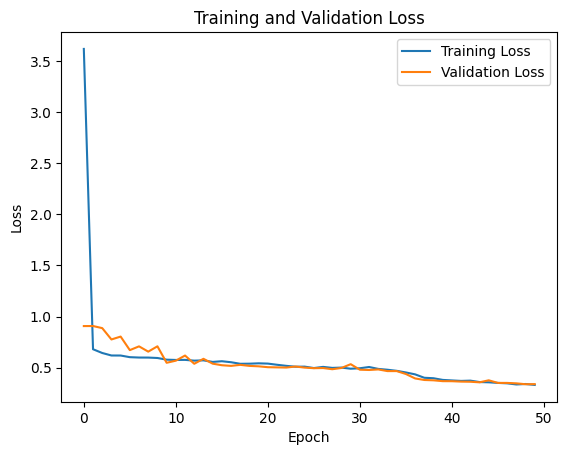

In [35]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
data_1)i = 31
print(Y_test[i])

data_1 = np.reshape(X_test[i], (1, 608,608,1))
my_model_2.predict(

[[1.         0.6326589  0.66129035 0.8965517  0.7326613 ]]
1/1 [==============================] - 0s 99ms/step


array([[[ 0.9967803 ,  0.4941283 ,  0.48914087, -0.03374406,
          0.6286531 ]]], dtype=float32)

In [40]:
predictions = my_model_2.predict(X_test)
# pred_labels = (predictions > 0.9).astype(int)
# accuracy = np.mean(pred_labels == Y_test)
accuracy = np.mean(predictions == Y_test)
print(f'Test accuracy: {accuracy*100:.2f}%')



5/5 [==============================] - 14s 3s/step
Test accuracy: 0.00%


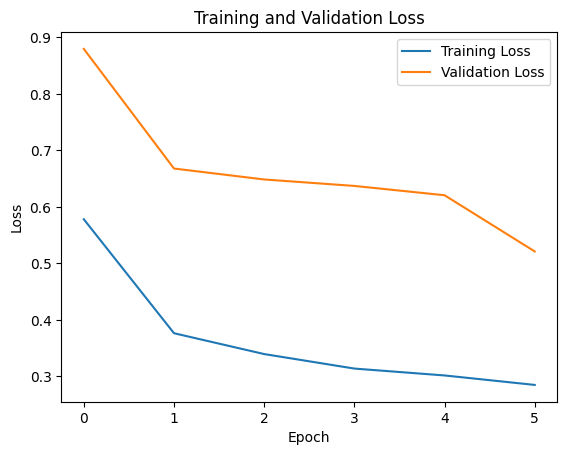

In [27]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
my_model_2.save('my_model_2.h5')

In [42]:
## we can use this later (1/6/2023).Cell 35 is the last training graph after 50 epochs.

loaded_model_1 = load_model('my_model_2.h5', custom_objects={'combined_loss': combined_loss})


In [43]:
print(loaded_model_1.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 608, 608, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  288         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                           

In [21]:
epoch = 75
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
my_model_2.compile(loss = combined_loss, optimizer = opt)
history = my_model_2.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/75


2023-05-30 01:38:35.697211: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


65/65 [==============================] - 1005s 15s/step - loss: 0.6594 - val_loss: 0.7716
Epoch 2/75
65/65 [==============================] - 1150s 18s/step - loss: 0.4627 - val_loss: 0.6582
Epoch 3/75
65/65 [==============================] - 1011s 16s/step - loss: 0.4393 - val_loss: 0.5729
Epoch 4/75
65/65 [==============================] - 993s 15s/step - loss: 0.4211 - val_loss: 0.5018
Epoch 5/75
65/65 [==============================] - 1020s 16s/step - loss: 0.4222 - val_loss: 0.6508
Epoch 6/75
65/65 [==============================] - 1003s 15s/step - loss: 0.4117 - val_loss: 0.4816
Epoch 7/75
65/65 [==============================] - 999s 15s/step - loss: 0.3967 - val_loss: 0.4331
Epoch 8/75
65/65 [==============================] - 1043s 16s/step - loss: 0.3805 - val_loss: 0.4593
Epoch 9/75
65/65 [==============================] - 1083s 17s/step - loss: 0.3701 - val_loss: 0.3267
Epoch 10/75
65/65 [==============================] - 1112s 17s/step - loss: 0.3612 - val_loss: 0.3632
Ep

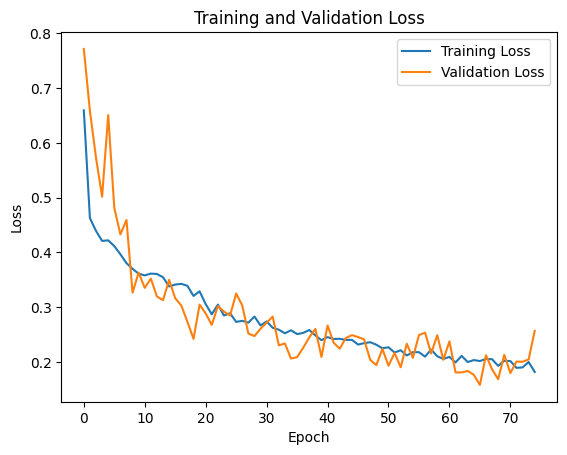

In [22]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
predictions = my_model_2.predict(X_test)
# pred_labels = (predictions > 0.9).astype(int)
# accuracy = np.mean(pred_labels == Y_test)
accuracy = np.mean(predictions == Y_test)
print(f'Test accuracy: {accuracy*100:.2f}%')
print('==================================')
# print(my_model_1.predict(X_test[0]))
print(Y_test[0])


5/5 [==============================] - 14s 3s/step
Test accuracy: 0.00%
[[0. 0. 0. 0. 0.]]


In [30]:
Y_test[10]

array([[1.        , 0.6337988 , 0.37862903, 0.89769167, 0.7326613 ]],
      dtype=float32)

In [28]:
X_test[0].shape

(608, 608, 1)

In [29]:
data_1 = np.reshape(X_test[0], (1, 608,608,1))
my_model_2.predict(data_1)

1/1 [==============================] - 0s 116ms/step


array([[[ 0.1515838 ,  0.1200463 ,  0.076968  ,  0.07163682,
         -0.03877829]]], dtype=float32)

In [37]:
i=15

print(Y_test[i])
             

[[1.         0.631234   0.68225807 0.89626676 0.7326613 ]]


In [39]:
data_1 = np.reshape(X_test[i], (1, 608,608,1))
my_model_2.predict(data_1)

1/1 [==============================] - 0s 95ms/step


array([[[0.798893  , 0.28526697, 0.35655284, 0.4476331 , 0.44761184]]],
      dtype=float32)

In [19]:


def binary_focal_loss(gamma=2., alpha=.25):
    
    def binary_focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = tf.keras.backend.epsilon()
        # clip to prevent NaN values
        pt_1 = tf.clip_by_value(pt_1, epsilon, 1. - epsilon)
        pt_0 = tf.clip_by_value(pt_0, epsilon, 1. - epsilon)

        return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) \
               -tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

    return binary_focal_loss_fixed


def smooth_l1_loss(sigma=3.0):
    
    def smooth_l1_loss_fixed(y_true, y_pred):
        
        abs_error = tf.abs(y_true - y_pred)
        quadratic = tf.minimum(abs_error, sigma)
        linear = (abs_error - quadratic)
        loss = (0.5 * tf.square(quadratic)) + (sigma * linear)
        
        return tf.reduce_mean(loss)

    return smooth_l1_loss_fixed


def combined_loss(alpha=0.25, gamma=2.0, sigma=3.0):

    def combined_loss_fixed(y_true, y_pred):
        
        class_true, loc_true = y_true[:, :, :1], y_true[:, :, 1:]
        class_pred, loc_pred = y_pred[:, :, :1], y_pred[:, :, 1:]
        
        class_loss = binary_focal_loss(gamma=gamma,alpha=alpha)(class_true, class_pred)
        loc_loss = smooth_l1_loss(sigma=sigma)(loc_true, loc_pred)
        combo_loss = class_loss * 0.5 + loc_loss

        return combo_loss

    return combined_loss_fixed


In [18]:
def make_my_model_2():
    input_image = Input(shape=(608, 608, 1))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    x = Dropout(0.2)(x)

    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 36}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 37}], skip = False)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    y = Dense(1, activation = 'sigmoid')(x)
    # z = Dense(4, activation = 'linear')(x)
    z = Dense(4)(x)
    z = LeakyReLU(alpha=0.1)(z)

    y_z = concatenate([y,z])
    final = Reshape((1,5))(y_z)

    model = Model(input_image, final)

    return model

In [19]:
input_size = (target_w, target_h, 1)
my_model_4= make_my_model_2()
print(my_model_4.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                             

In [45]:


# define model architecture and compile

epoch = 3
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
my_model_3.compile(loss=combined_loss(alpha=0.25, gamma=2.0, sigma=3.0), optimizer=opt)
history = my_model_3.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))



Epoch 1/3
65/65 [==============================] - 1077s 17s/step - loss: 0.2494 - val_loss: 0.1937
Epoch 2/3
65/65 [==============================] - 1213s 19s/step - loss: 0.1110 - val_loss: 0.1313
Epoch 3/3
65/65 [==============================] - 1198s 18s/step - loss: 0.1008 - val_loss: 0.1468


In [46]:
epoch = 50
#opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#my_model_3.compile(loss=combined_loss(alpha=0.25, gamma=2.0, sigma=3.0), optimizer=opt)
history = my_model_3.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))


Epoch 1/50
65/65 [==============================] - 1125s 17s/step - loss: 0.0983 - val_loss: 0.1291
Epoch 2/50
65/65 [==============================] - 1300s 20s/step - loss: 0.0895 - val_loss: 0.0967
Epoch 3/50
65/65 [==============================] - 1336s 21s/step - loss: 0.0900 - val_loss: 0.1062
Epoch 4/50
65/65 [==============================] - 1294s 20s/step - loss: 0.0853 - val_loss: 0.0944
Epoch 5/50
65/65 [==============================] - 1081s 17s/step - loss: 0.0860 - val_loss: 0.0999
Epoch 6/50
65/65 [==============================] - 1086s 17s/step - loss: 0.0828 - val_loss: 0.0666
Epoch 7/50
65/65 [==============================] - 1080s 17s/step - loss: 0.0796 - val_loss: 0.0672
Epoch 8/50
65/65 [==============================] - 1062s 16s/step - loss: 0.0764 - val_loss: 0.0596
Epoch 9/50
65/65 [==============================] - 1050s 16s/step - loss: 0.0784 - val_loss: 0.0672
Epoch 10/50
65/65 [==============================] - 1053s 16s/step - loss: 0.0765 - val_lo

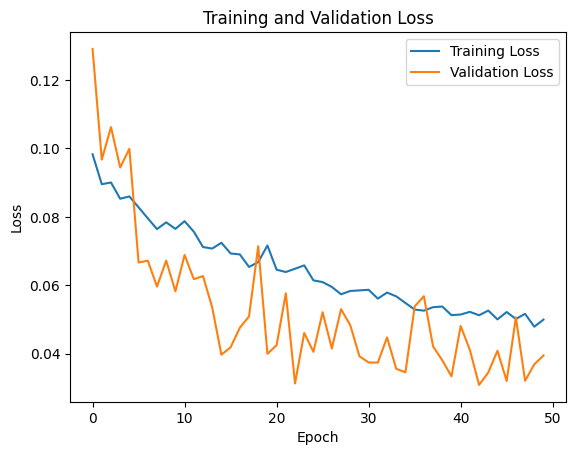

In [47]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
i = 11
print(Y_test[i])

data_1 = np.reshape(X_test[i], (1, 608,608,1))
my_model_3.predict(data_1)

[[1.         0.6630303  0.6419608  0.9769697  0.75529414]]
1/1 [==============================] - 0s 126ms/step


array([[[0.75410694, 0.38230875, 0.45097607, 0.60299104, 0.56906056]]],
      dtype=float32)

In [73]:
# accuracy of the model

from math import sqrt

predictions = my_model_3.predict(X_test)

MAE = np.mean(abs(predictions - Y_test))

RMSE = math.sqrt(np.mean(np.square(predictions - Y_test)))

print(f'Test accuracy - MAE: {MAE*100:.2f}%')
print(f'Test accuracy - RMSE: {RMSE*100:.2f}%')


5/5 [==============================] - 14s 3s/step
Test accuracy - MAE: 21.12%
Test accuracy - RMSE: 25.17%


In [21]:
epoch = 50
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
my_model_4.compile(loss=combined_loss(alpha=0.25, gamma=2.0, sigma=3.0), optimizer=opt)
history = my_model_4.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))


Epoch 1/50
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-06-02 19:50:45.705540: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


65/65 [==============================] - 948s 15s/step - loss: 0.2007 - val_loss: 0.2339
Epoch 2/50
65/65 [==============================] - 1101s 17s/step - loss: 0.1112 - val_loss: 0.1678
Epoch 3/50
65/65 [==============================] - 1166s 18s/step - loss: 0.0981 - val_loss: 0.1831
Epoch 4/50
65/65 [==============================] - 1176s 18s/step - loss: 0.0896 - val_loss: 0.1172
Epoch 5/50
65/65 [==============================] - 1183s 18s/step - loss: 0.0878 - val_loss: 0.1990
Epoch 6/50
65/65 [==============================] - 1001s 15s/step - loss: 0.0848 - val_loss: 0.0984
Epoch 7/50
65/65 [==============================] - 970s 15s/step - loss: 0.0868 - val_loss: 0.0709
Epoch 8/50
65/65 [==============================] - 949s 15s/step - loss: 0.0786 - val_loss: 0.0807
Epoch 9/50
65/65 [==============================] - 955s 15s/step - loss: 0.0809 - val_loss: 0.0691
Epoch 10/50
65/65 [==============================] - 961s 15s/step - loss: 0.0748 - val_loss: 0.0705
Epoch

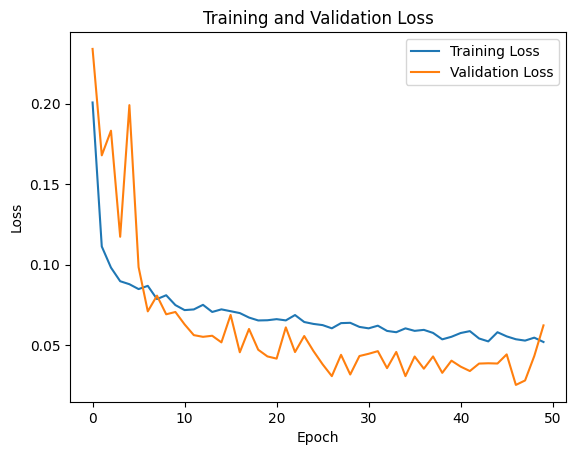

In [22]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# accuracy of the model

from math import sqrt

predictions = my_model_4.predict(X_test)

MAE = np.mean(abs(predictions - Y_test))

RMSE = math.sqrt(np.mean(np.square(predictions - Y_test)))

print(f'Test accuracy - MAE: {MAE*100:.2f}%')
print(f'Test accuracy - RMSE: {RMSE*100:.2f}%')


5/5 [==============================] - 14s 3s/step
Test accuracy - MAE: 25.62%
Test accuracy - RMSE: 29.02%


In [19]:
def make_my_model_3():
    input_image = Input(shape=(608, 608, 1))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    x = Dropout(0.2)(x)
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    

    x = Dropout(0.2)(x)

    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 36}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 37}], skip = False)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    y = Dense(1, activation = 'sigmoid')(x)
    # z = Dense(4, activation = 'linear')(x)
    z = Dense(4)(x)
    z = LeakyReLU(alpha=0.1)(z)

    y_z = concatenate([y,z])
    final = Reshape((1,5))(y_z)

    model = Model(input_image, final)

    return model

In [20]:
input_size = (target_w, target_h, 1)
my_model_5 =  make_my_model_3()
print(my_model_5.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                             

In [21]:
epoch = 50
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
my_model_5.compile(loss=combined_loss(alpha=0.25, gamma=2.0, sigma=3.0), optimizer=opt)
history = my_model_5.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))


Epoch 1/50


2023-06-03 18:14:14.115846: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
65/65 [==============================] - 1937s 30s/step - loss: 0.2255 - val_loss: 0.2087
Epoch 2/50
65/65 [==============================] - 2028s 31s/step - loss: 0.1208 - val_loss: 0.1581
Epoch 3/50
65/65 [==============================] - 1804s 28s/step - loss: 0.1045 - val_loss: 0.1347
Epoch 4/50
65/65 [==============================] - 1722s 27s/step - loss: 0.0987 - val_loss: 0.1550
Epoch 5/50
65/65 [==============================] - 1768s 27s/step - loss: 0.0935 - val_loss: 0.1492
Epoch 6/50
65/65 [==============================] - 2018s 31s/step - loss: 0.0897 - val_loss: 0.1436
Epoch 7/50
65/65 [==============================] - 1843s 28s/step - loss: 0.0897 - val_loss: 0.1254
Epoch 8/50
65/65 [==============================] - 1949s 30s/step - loss: 0.0879 - val_loss: 0.1095
Ep

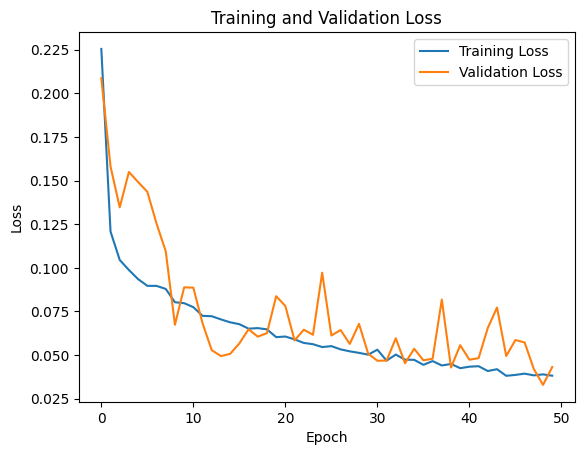

In [22]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# accuracy of the model

from math import sqrt

predictions = my_model_5.predict(X_test)

MAE = np.mean(abs(predictions - Y_test))

RMSE = math.sqrt(np.mean(np.square(predictions - Y_test)))

print(f'Test accuracy - MAE: {MAE*100:.2f}%')
print(f'Test accuracy - RMSE: {RMSE*100:.2f}%')


5/5 [==============================] - 27s 5s/step
Test accuracy - MAE: 18.24%
Test accuracy - RMSE: 23.35%


In [19]:
def make_my_model_4():
    input_image = Input(shape=(608, 608, 1))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    x = Dropout(0.2)(x)

    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 36}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 37}], skip = False)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    y = Dense(1, activation = 'sigmoid')(x)
    # z = Dense(4, activation = 'linear')(x)
    z = Dense(4)(x)
    z = LeakyReLU(alpha=0.1)(z)

    y_z = concatenate([y,z])
    final = Reshape((1,5))(y_z)

    model = Model(input_image, final)

    return model

In [20]:
input_size = (target_w, target_h, 1)
my_model_6 =  make_my_model_4()
print(my_model_6.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                             

In [21]:
epoch = 50
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
my_model_6.compile(loss=combined_loss(alpha=0.25, gamma=2.0, sigma=3.0), optimizer=opt)
history = my_model_6.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))


Epoch 1/50
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-06-04 22:51:59.015387: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


65/65 [==============================] - 922s 14s/step - loss: 0.7735 - val_loss: 0.2218
Epoch 2/50
65/65 [==============================] - 1025s 16s/step - loss: 0.2307 - val_loss: 0.2748
Epoch 3/50
65/65 [==============================] - 1025s 16s/step - loss: 0.2371 - val_loss: 0.2759
Epoch 4/50
65/65 [==============================] - 1038s 16s/step - loss: 0.2305 - val_loss: 0.2633
Epoch 5/50
65/65 [==============================] - 998s 15s/step - loss: 0.2260 - val_loss: 0.2611
Epoch 6/50
65/65 [==============================] - 982s 15s/step - loss: 0.2194 - val_loss: 0.2154
Epoch 7/50
65/65 [==============================] - 984s 15s/step - loss: 0.2077 - val_loss: 0.2019
Epoch 8/50
65/65 [==============================] - 972s 15s/step - loss: 0.2011 - val_loss: 0.2053
Epoch 9/50
65/65 [==============================] - 984s 15s/step - loss: 0.1963 - val_loss: 0.1949
Epoch 10/50
65/65 [==============================] - 981s 15s/step - loss: 0.1942 - val_loss: 0.1839
Epoch 1

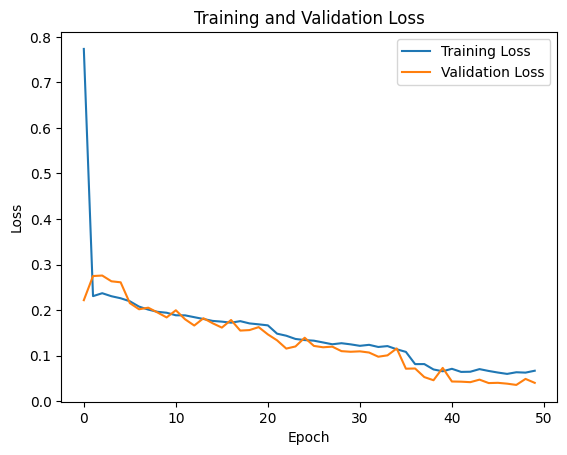

In [22]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# accuracy of the model

from math import sqrt

predictions = my_model_6.predict(X_test)

MAE = np.mean(abs(predictions - Y_test))

RMSE = math.sqrt(np.mean(np.square(predictions - Y_test)))

print(f'Test accuracy - MAE: {MAE*100:.2f}%')
print(f'Test accuracy - RMSE: {RMSE*100:.2f}%')


5/5 [==============================] - 13s 2s/step
Test accuracy - MAE: 19.52%
Test accuracy - RMSE: 23.11%


In [24]:
predictions.shape

(144, 1, 5)

In [27]:
# accuracy of the model

from math import sqrt

predictions = my_model_6.predict(X_test)

MAE = np.mean(abs(predictions[:,:,1:] - Y_test[:,:,1:]))

RMSE = math.sqrt(np.mean(np.square(predictions[:,:,1:] - Y_test[:,:,1:])))

print(f'Test accuracy - MAE: {MAE*100:.2f}%')
print(f'Test accuracy - RMSE: {RMSE*100:.2f}%')

5/5 [==============================] - 13s 2s/step
Test accuracy - MAE: 18.76%
Test accuracy - RMSE: 21.71%


In [22]:
## 6th June, 2023
def make_my_model_4():
    input_image = Input(shape=(608, 608, 1))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    x = Dropout(0.2)(x)
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    x = Dropout(0.2)(x)
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    

    x = Dropout(0.2)(x)

    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 40}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41}], skip = False)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    y = Dense(1, activation = 'sigmoid')(x)
    # z = Dense(4, activation = 'linear')(x)
    z = Dense(4)(x)
    z = LeakyReLU(alpha=0.1)(z)

    y_z = concatenate([y,z])
    final = Reshape((1,5))(y_z)

    model = Model(input_image, final)

    return model

In [23]:
input_size = (target_w, target_h, 1)
my_model_7 =  make_my_model_4()
print(my_model_7.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 608, 608, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  288         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                             

In [25]:
from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay(epoch, initial_lr, drop, epochs_drop):
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

#from tensorflow.keras.callbacks import LearningRateScheduler

initial_learning_rate = 0.01
lr_decay = 0.01
epochs_drop = 10

# Define the learning rate schedule using the step decay function
lr_scheduler = LearningRateScheduler(lambda epoch: step_decay(epoch, initial_learning_rate, lr_decay, epochs_drop))

# Pass the learning rate scheduler to your model.fit() method as a callback
#model.fit(train_data, train_labels, epochs=num_epochs, batch_size=batch_size, callbacks=[lr_scheduler])


In [25]:
epoch = 100
opt = Adam(learning_rate=initial_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
my_model_7.compile(loss=combined_loss(alpha=0.25, gamma=2.0, sigma=3.0), optimizer=opt)
history = my_model_7.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val), callbacks=[lr_scheduler])


Epoch 1/100


2023-06-06 21:59:58.262572: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
65/65 [==============================] - 1824s 28s/step - loss: 18.4632 - val_loss: 931418.5000 - lr: 0.1000
Epoch 2/100
65/65 [==============================] - 1798s 28s/step - loss: 0.2745 - val_loss: 90.7466 - lr: 0.1000
Epoch 3/100
65/65 [==============================] - 2077s 32s/step - loss: 0.0596 - val_loss: 0.0610 - lr: 0.1000
Epoch 4/100
65/65 [==============================] - 1970s 30s/step - loss: 0.0596 - val_loss: 0.0608 - lr: 0.1000
Epoch 5/100
65/65 [==============================] - 1872s 29s/step - loss: 0.0596 - val_loss: 0.0607 - lr: 0.1000
Epoch 6/100
65/65 [==============================] - 1844s 28s/step - loss: 0.0599 - val_loss: 0.0608 - lr: 0.1000
Epoch 7/100
65/65 [==============================] - 1849s 28s/step - loss: 0.0595 - val_loss: 0.0607 - lr: 0.1000

KeyboardInterrupt: 

In [28]:
## MODEL which gave good result
# 5/8 dropout

def make_yolov3_model_drop():
    input_image = Input(shape=(608, 608, 1))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    x = Dropout(0.2)(x)
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    x = Dropout(0.2)(x)
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
    
    x = Dropout(0.2)(x)
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    x = Dropout(0.2)(x)
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    x = Dropout(0.2)(x)
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    
    # Layer 62 => 65
##    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
##                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])


    x = Dropout(0.2)(x)
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    
     # Layer 66 => 74
##    for i in range(3):
##        x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
##                            {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

    x = Dropout(0.2)(x)
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 75 => 79
##    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 80 => 82
#    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
#                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = Dropout(0.2)(x)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    x = Dropout(0.2)(x)

    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 101},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 102},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 103}], skip=False)
#    x = Dropout(0.2)(x)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter':   18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

#===============================================================================================================
#    # Layer 95 => 980
#    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
#    x = UpSampling2D(2)(x)
#    x = concatenate([x, skip_36])

#    # Layer 99 => 106
#    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
#                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
#                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
#                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

#    model = Model(input_image, [yolo_82, yolo_94, yolo_106])

    #final = Reshape((grid_y_axis,grid_x_axis,3,6))(yolo_94)
    #final = Reshape((19,19,3,6))(yolo_94)
    #model = Model(input_image, final)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    y = Dense(1, activation = 'sigmoid')(x)
    # z = Dense(4, activation = 'linear')(x)
    z = Dense(4)(x)
    z = LeakyReLU(alpha=0.1)(z)

    y_z = concatenate([y,z])
    final = Reshape((1,5))(y_z)

    model = Model(input_image, final)
    return model


In [29]:
nput_size = (target_w, target_h, 1)
my_model_7 =  make_yolov3_model_drop()
print(my_model_7.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 608, 608, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  288         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                           

In [30]:
epoch = 50
opt = Adam(learning_rate=initial_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
my_model_7.compile(loss=combined_loss(alpha=0.25, gamma=2.0, sigma=3.0), optimizer=opt)
history = my_model_7.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val), callbacks=[lr_scheduler])


Epoch 1/50
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
65/65 [==============================] - 3792s 58s/step - loss: 357.2857 - val_loss: 1832354316288.0000 - lr: 0.1000
Epoch 2/50
65/65 [==============================] - 3388s 52s/step - loss: 0.1168 - val_loss: 9759855.0000 - lr: 0.1000
Epoch 3/50
65/65 [==============================] - 3492s 54s/step - loss: 0.0637 - val_loss: 255135.8594 - lr: 0.1000
Epoch 4/50
65/65 [==============================] - 3733s 58s/step - loss: 0.0644 - val_loss: 5765.0513 - lr: 0.1000
Epoch 5/50
65/65 [==============================] - 3390s 52s/step - loss: 0.0634 - val_loss: 18.3326 - lr: 0.1000
Epoch 6/50
65/65 [==============================] - 3430s 53s/step - loss: 0.0644 - val_loss: 0.9413 - lr: 0.1000
Epoch 7/50
65/65 [==============================] - 3604s 56s/step - loss: 0.0638 - va

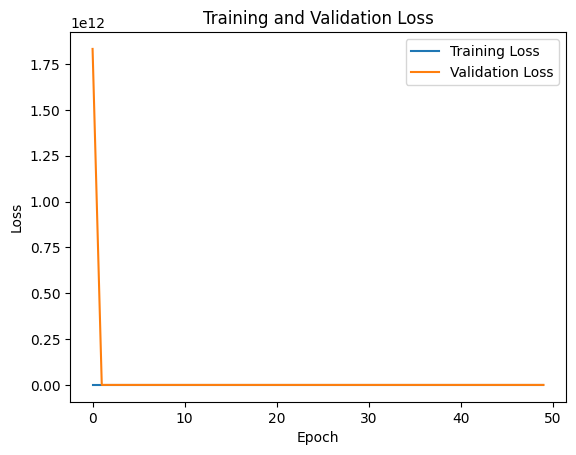

In [31]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
# accuracy of the model

from math import sqrt

predictions = my_model_7.predict(X_test)

MAE = np.mean(abs(predictions - Y_test))

RMSE = math.sqrt(np.mean(np.square(predictions - Y_test)))

print(f'Test accuracy - MAE: {MAE*100:.2f}%')
print(f'Test accuracy - RMSE: {RMSE*100:.2f}%')


5/5 [==============================] - 60s 12s/step
Test accuracy - MAE: 22.91%
Test accuracy - RMSE: 28.49%


In [5]:
def make_my_model_new_1():
    input_image = Input(shape=(608, 608, 1))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    x = Dropout(0.2)(x)
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    

    x = Dropout(0.2)(x)

    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 36}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 37}], skip = False)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    # x = Dropout(0.2)(x)
    y = Dense(1, activation = 'sigmoid')(x)
    z = Dense(4, activation = 'linear')(x)
    # z = Dense(4)(x)
    # z = LeakyReLU(alpha=0.1)(z)

    y_z = concatenate([y,z])
    final = Reshape((1,5))(y_z)

    model = Model(input_image, final)

    return model

In [6]:
input_size = (target_w, target_h, 1)
my_new_model_1 =  make_my_model_new_1()
print(my_new_model_1.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                             

In [21]:
from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay(epoch, initial_lr, drop, epochs_drop):
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

#from tensorflow.keras.callbacks import LearningRateScheduler

initial_learning_rate = 0.01
lr_decay = 0.1
epochs_drop = 50

# Define the learning rate schedule using the step decay function
lr_scheduler = LearningRateScheduler(lambda epoch: step_decay(epoch, initial_learning_rate, lr_decay, epochs_drop))

# Pass the learning rate scheduler to your model.fit() method as a callback
#model.fit(train_data, train_labels, epochs=num_epochs, batch_size=batch_size, callbacks=[lr_scheduler])


In [7]:
## exponential lr decay
# from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

init_lr = 0.001 # Initial learning rate
decay = 0.0001 # Decay rate

def lr_scheduler(epoch):
    return init_lr * pow(1. - decay, float(epoch))

opt = Adam(learning_rate=init_lr)
lr_scheduler = LearningRateScheduler(lr_scheduler)

# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(x_train, y_train, callbacks=[lr_callback])



In [12]:
epoch = 100
# opt = Adam(learning_rate=initial_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
my_new_model_1.compile(loss=combined_loss(alpha=0.25, gamma=2.0, sigma=3.0), optimizer=opt)
history = my_new_model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val), callbacks=[lr_scheduler])


Epoch 1/100


2023-06-11 23:35:56.621277: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


65/65 [==============================] - 1693s 26s/step - loss: 3.6226 - val_loss: 0.9884 - lr: 0.0010
Epoch 2/100
65/65 [==============================] - 1744s 27s/step - loss: 0.2275 - val_loss: 0.2158 - lr: 9.9990e-04
Epoch 3/100
65/65 [==============================] - 1754s 27s/step - loss: 0.2011 - val_loss: 0.1906 - lr: 9.9980e-04
Epoch 4/100
65/65 [==============================] - 1831s 28s/step - loss: 0.1777 - val_loss: 0.1678 - lr: 9.9970e-04
Epoch 5/100
65/65 [==============================] - 1941s 30s/step - loss: 0.1568 - val_loss: 0.1474 - lr: 9.9960e-04
Epoch 6/100
65/65 [==============================] - 1942s 30s/step - loss: 0.1387 - val_loss: 0.1300 - lr: 9.9950e-04
Epoch 7/100
65/65 [==============================] - 1945s 30s/step - loss: 0.1233 - val_loss: 0.1154 - lr: 9.9940e-04
Epoch 8/100
65/65 [==============================] - 1962s 30s/step - loss: 0.1104 - val_loss: 0.1030 - lr: 9.9930e-04
Epoch 9/100
65/65 [==============================] - 1948s 30s/s

In [ ]:
import pickle

# Assuming you have already defined X_train, Y_train, X_val, Y_val, X_test and Y_test

# Save the variables
with open('data.pickle', 'wb') as f:
    pickle.dump([X_train, Y_train, X_val, Y_val, X_test, Y_test], f)


In [21]:
import pickle

# Load the variables
with open('data.pickle', 'rb') as f:
    X_train, Y_train, X_val, Y_val, X_test, Y_test = pickle.load(f)


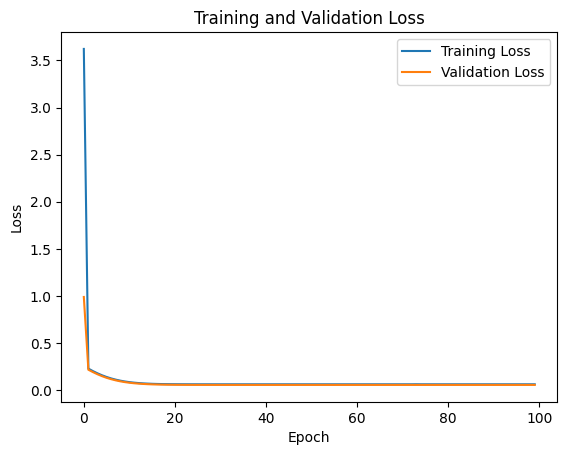

In [13]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# accuracy of the model

from math import sqrt

predictions = my_new_model_1.predict(X_test)

MAE = np.mean(abs(predictions - Y_test))

RMSE = math.sqrt(np.mean(np.square(predictions - Y_test)))

print(f'Test accuracy - MAE: {MAE*100:.2f}%')
print(f'Test accuracy - RMSE: {RMSE*100:.2f}%')


5/5 [==============================] - 28s 5s/step
Test accuracy - MAE: 24.91%
Test accuracy - RMSE: 31.72%


In [10]:
from keras.callbacks import LearningRateScheduler

def step_decay(epoch, initial_lr, drop, epochs_drop):
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

#from tensorflow.keras.callbacks import LearningRateScheduler

initial_learning_rate = 0.001
lr_decay = 0.1
epochs_drop = 30

# Define the learning rate schedule using the step decay function
lr_scheduler = LearningRateScheduler(lambda epoch: step_decay(epoch, initial_learning_rate, lr_decay, epochs_drop))


In [20]:
history = my_new_model_1.fit(X_train,Y_train, epochs=20, batch_size = 64, validation_data=(X_val,Y_val), callbacks=[lr_scheduler])


Epoch 1/20


: 

: 

In [11]:
epoch = 75
opt = Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
my_new_model_1.compile(loss=combined_loss(alpha=0.25, gamma=2.0, sigma=3.0), optimizer=opt)
history = my_new_model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 32, validation_data=(X_val,Y_val), callbacks=[lr_scheduler])



Epoch 1/75
33/33 [==============================] - 2596s 79s/step - loss: 9.5513 - val_loss: 5668.6211 - lr: 0.0010
Epoch 2/75
33/33 [==============================] - 2586s 78s/step - loss: 0.2722 - val_loss: 4.2199 - lr: 0.0010
Epoch 3/75
33/33 [==============================] - 2494s 76s/step - loss: 0.1635 - val_loss: 0.3161 - lr: 0.0010
Epoch 4/75
33/33 [==============================] - 2670s 81s/step - loss: 0.1308 - val_loss: 0.1797 - lr: 0.0010
Epoch 5/75
33/33 [==============================] - 2810s 86s/step - loss: 0.1160 - val_loss: 0.2356 - lr: 0.0010
Epoch 6/75
33/33 [==============================] - 2617s 79s/step - loss: 0.1270 - val_loss: 0.1236 - lr: 0.0010
Epoch 7/75
33/33 [==============================] - 2546s 77s/step - loss: 0.1301 - val_loss: 0.1408 - lr: 0.0010
Epoch 8/75
33/33 [==============================] - 2437s 74s/step - loss: 0.0945 - val_loss: 0.1049 - lr: 0.0010
Epoch 9/75
33/33 [==============================] - 2482s 75s/step - loss: 0.1407 - v

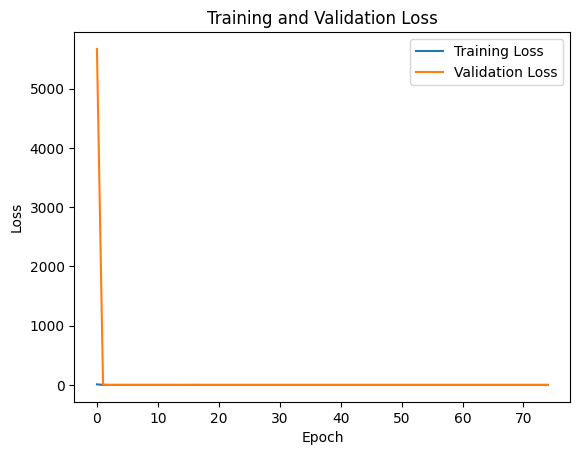

In [12]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
from math import sqrt

predictions = my_new_model_1.predict(X_test)

MAE = np.mean(abs(predictions - Y_test))

RMSE = math.sqrt(np.mean(np.square(predictions - Y_test)))

print(f'Test accuracy - MAE: {MAE*100:.2f}%')
print(f'Test accuracy - RMSE: {RMSE*100:.2f}%')


5/5 [==============================] - 28s 5s/step
Test accuracy - MAE: 13.62%
Test accuracy - RMSE: 18.76%


In [1]:
## MODEL which gave good result
# 5/8 dropout

def make_yolov3_model_drop():
    input_image = Input(shape=(608, 608, 1))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    x = Dropout(0.2)(x)
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    x = Dropout(0.2)(x)
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
    
    x = Dropout(0.2)(x)
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    x = Dropout(0.2)(x)
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x

    """    
    x = Dropout(0.2)(x)
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    
    # Layer 62 => 65
##    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
##                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])


    x = Dropout(0.2)(x)
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    
     # Layer 66 => 74
##    for i in range(3):
##        x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
##                            {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

    x = Dropout(0.2)(x)
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 75 => 79
##    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 80 => 82
#    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
#                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = Dropout(0.2)(x)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    x = Dropout(0.2)(x)

    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 101},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 102},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 103}], skip=False)
#    x = Dropout(0.2)(x)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter':   18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

#===============================================================================================================
#    # Layer 95 => 980
#    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
#    x = UpSampling2D(2)(x)
#    x = concatenate([x, skip_36])

#    # Layer 99 => 106
#    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
#                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
#                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
#                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

#    model = Model(input_image, [yolo_82, yolo_94, yolo_106])

    #final = Reshape((grid_y_axis,grid_x_axis,3,6))(yolo_94)
    #final = Reshape((19,19,3,6))(yolo_94)
    #model = Model(input_image, final)
    x = Flatten()(yolo_94)
#    x = Dense(128, activation='relu')(x)
#    x = Dropout(0.2)(x)
    y = Dense(1, activation = 'sigmoid')(x)
    z = Dense(4, activation = 'linear')(x)
    
#    y = LeakyReLU(alpha=0.1)(x)
#    z = Dense(5)(y)

    y_z = concatenate([y,z])
#    final = Reshape((1,5))(y_z)
    final = Reshape((1,5))(y_z)
"""
    final = skip_61
    model = Model(input_image, final)
    return model


In [2]:

my_new_model_2=  make_yolov3_model_drop()
print(my_new_model_2.summary())

NameError: name 'Input' is not defined

In [20]:
from keras.callbacks import LearningRateScheduler

def step_decay(epoch, initial_lr, drop, epochs_drop):
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

#from tensorflow.keras.callbacks import LearningRateScheduler

initial_learning_rate = 0.001
lr_decay = 0.1
epochs_drop = 25

# Define the learning rate schedule using the step decay function
lr_scheduler = LearningRateScheduler(lambda epoch: step_decay(epoch, initial_learning_rate, lr_decay, epochs_drop))


In [23]:
epoch = 75
opt = Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
my_new_model_2.compile(loss=combined_loss(alpha=0.25, gamma=2.0, sigma=3.0), optimizer=opt)
history = my_new_model_2.fit(X_train,Y_train, epochs=epoch, batch_size = 32, validation_data=(X_val,Y_val), callbacks=[lr_scheduler])


Epoch 1/75


2023-06-17 19:03:11.641844: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
33/33 [==============================] - 5386s 165s/step - loss: 1.1457 - val_loss: 15.2031 - lr: 0.0010
Epoch 2/75
33/33 [==============================] - 5260s 159s/step - loss: 0.1209 - val_loss: 0.3103 - lr: 0.0010
Epoch 3/75
33/33 [==============================] - 5239s 159s/step - loss: 0.0754 - val_loss: 0.0925 - lr: 0.0010
Epoch 4/75
33/33 [==============================] - 4212s 127s/step - loss: 0.0635 - val_loss: 0.0581 - lr: 0.0010
Epoch 5/75
33/33 [==============================] - 4103s 124s/step - loss: 0.0548 - val_loss: 0.0595 - lr: 0.0010
Epoch 6/75
33/33 [==============================] - 4127s 125s/step - loss: 0.0504 - val_loss: 0.0569 - lr: 0.0010
Epoch 7/75
33/33 [==============================] - 3970s 120s/step - loss: 0.0463 - val_loss: 0.0800 - lr: 0.0010
Epoc

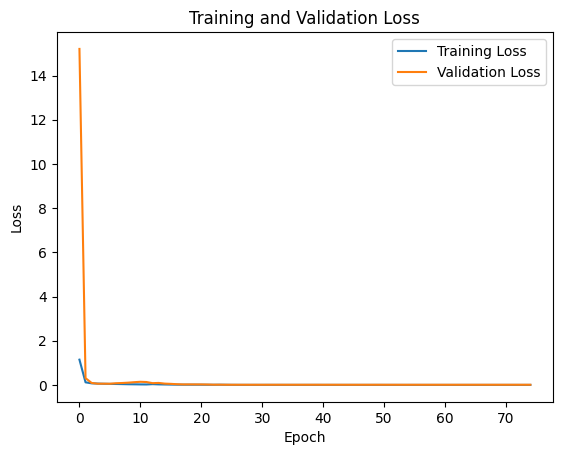

In [24]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
from math import sqrt

predictions = my_new_model_2.predict(X_test)

MAE = np.mean(abs(predictions - Y_test))

RMSE = math.sqrt(np.mean(np.square(predictions - Y_test)))

print(f'Test accuracy - MAE: {MAE*100:.2f}%')
print(f'Test accuracy - RMSE: {RMSE*100:.2f}%')


5/5 [==============================] - 58s 11s/step
Test accuracy - MAE: 8.84%
Test accuracy - RMSE: 13.59%
